In [43]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import pywt
import matlab.engine
import dippykit as dip
import ssim.ssimlib as pyssim
from PIL import Image
from keras.models import load_model
from skimage.exposure import match_histograms 
eng = matlab.engine.start_matlab()
eng.addpath("Function\InputWeights")
eng.addpath("Function\InputWeights_U")
eng.addpath("Function")


'C:\\Users\\ajayr\\Documents\\Masters\\3rd Sem\\Digital Image Processing\\Project\\Function\\InputWeights_U;C:\\Users\\ajayr\\Documents\\Masters\\3rd Sem\\Digital Image Processing\\Project\\Function\\InputWeights;C:\\Users\\ajayr\\Documents\\MATLAB;C:\\Program Files\\MATLAB\\R2023a\\toolbox\\matlab\\addon_enable_disable_management\\matlab;C:\\Program Files\\MATLAB\\R2023a\\toolbox\\matlab\\addon_updates\\matlab;C:\\Program Files\\MATLAB\\R2023a\\toolbox\\matlab\\addons;C:\\Program Files\\MATLAB\\R2023a\\toolbox\\matlab\\addons\\cef;C:\\Program Files\\MATLAB\\R2023a\\toolbox\\matlab\\addons\\fileexchange;C:\\Program Files\\MATLAB\\R2023a\\toolbox\\matlab\\addons\\supportpackages;C:\\Program Files\\MATLAB\\R2023a\\toolbox\\matlab\\addons_common\\matlab;C:\\Program Files\\MATLAB\\R2023a\\toolbox\\matlab\\addons_install_location\\matlab;C:\\Program Files\\MATLAB\\R2023a\\toolbox\\matlab\\addons_product;C:\\Program Files\\MATLAB\\R2023a\\toolbox\\matlab\\addons_product_support\\matlab;C:\\P

## Importing Dataset

In [3]:
path = 'C:\\Users\\ajayr\\Documents\\Masters\\3rd Sem\\Digital Image Processing\\Project\\SIDD\\Data\\'
noisy_lst = []
gt_lst = []
folders = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]

In [4]:
for folder_name in folders:
    folder_path = os.path.join(path, folder_name)

    # Get a list of files in the directory
    file_list = os.listdir(folder_path)

    # Check if "NOISY" and "GT" are in the list of files
    noisy_files = [os.path.join(folder_path, file) for file in file_list if "NOISY" in file and "._" not in file]
    gt_files = [os.path.join(folder_path, file) for file in file_list if "GT" in file and "._" not in file]

    noisy_lst.extend(noisy_files)
    gt_lst.extend(gt_files)

In [5]:
noisy_imgs = []
gt_imgs = []
for i,j in zip(noisy_lst,gt_lst):
    # print(str(i))
    noisy_img = cv2.imread(i)
    gt_img = cv2.imread(j)
    gt_img=cv2.resize(gt_img,(256,256))
    noisy_img=cv2.resize(noisy_img,(256,256))
    noisy_imgs.append(noisy_img)
    gt_imgs.append(gt_img)

    # plt.figure(figsize=(12, 6)) 

    # plt.subplot(1,2,1)
    # plt.imshow(noisy_img)
    # plt.title("Noisy Image")

    # plt.subplot(1,2,2)
    # plt.imshow(gt_img)
    # plt.title("GT Image")
    # plt.show()

[2023-11-29 23:18:44,650] DEBUG: Loaded backend module://matplotlib_inline.backend_inline version unknown.
[2023-11-29 23:18:44,652] DEBUG: Loaded backend module://matplotlib_inline.backend_inline version unknown.
[2023-11-29 23:18:44,658] DEBUG: findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
[2023-11-29 23:18:44,659] DEBUG: findfont: score(FontEntry(fname='c:\\Users\\ajayr\\miniconda3\\envs\\dip_project\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSerif.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05


[2023-11-29 23:18:44,660] DEBUG: findfont: score(FontEntry(fname='c:\\Users\\ajayr\\miniconda3\\envs\\dip_project\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans-Bold.ttf', name='DejaVu Sans', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 0.33499999999999996
[2023-11-29 23:18:44,660] DEBUG: findfont: score(FontEntry(fname='c:\\Users\\ajayr\\miniconda3\\envs\\dip_project\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSerif-BoldItalic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
[2023-11-29 23:18:44,661] DEBUG: findfont: score(FontEntry(fname='c:\\Users\\ajayr\\miniconda3\\envs\\dip_project\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXSizFourSymBol.ttf', name='STIXSizeFourSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
[2023-11-29 23:18:44,662] DEBUG: findfont: score(FontEntry(fname='c

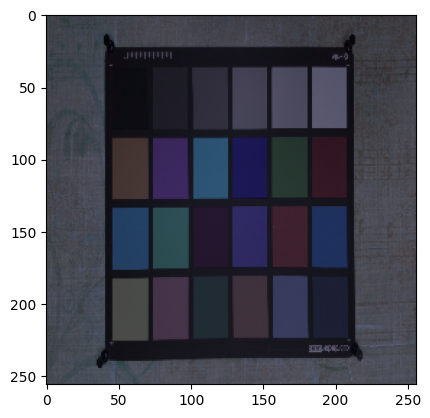

In [6]:
plt.imshow(gt_imgs[0])

## Functions

In [7]:
def display_plots(gt_img,noisy_img,denoisy_img):
    # Create a figure with three subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

    # Display the first image
    ax1.imshow(gt_img, cmap='gray')
    ax1.set_title('Ground Truth')
    ax1.axis('off')

    # Display the second image
    ax2.imshow(noisy_img, cmap='gray')
    ax2.set_title('Noisy Image')
    ax2.axis('off')

    # Display the third image
    ax3.imshow(denoisy_img, cmap='gray')
    ax3.set_title('Denoised Image')
    ax3.axis('off')

    # Adjust layout to prevent clipping of titles
    plt.tight_layout()

    # Show the plot
    plt.show()


In [8]:
def nlmeans_denoise(image, h=3, templateWindowSize=7, searchWindowSize=21):
    # Perform Non-Local Means Denoising using OpenCV
    return cv2.fastNlMeansDenoising(image, None, h, templateWindowSize, searchWindowSize)

def wavelet_denoise(img, threshold=20):

    channels = cv2.split(img)

    # Apply wavelet denoising to each channel independently
    denoised_channels = []
    for channel in channels:
        # Perform 2D wavelet transform
        coeffs = pywt.dwt2(channel, 'bior1.3')

        # Thresholding: Set small coefficients to zero
        coeffs = tuple(map(lambda x: pywt.threshold(x, threshold, mode='soft'), coeffs))

        # Inverse 2D wavelet transform
        denoised_channel = pywt.idwt2(coeffs, 'bior1.3')

        # Clip values to be in the valid range [0, 255]
        denoised_channel = np.clip(denoised_channel, 0, 255)

        # Convert to uint8 (required for image display)
        denoised_channel = denoised_channel.astype(np.uint8)

        denoised_channels.append(denoised_channel)

    # Merge the denoised channels back into an RGB image
    denoised_img = cv2.merge(denoised_channels)

    return denoised_img

def combine_denoising_methods(image):

    # Apply NLMeans denoising
    nlmeans_denoised = nlmeans_denoise(image)

    # Apply wavelet denoising
    wavelet_denoised = wavelet_denoise(image)

    nlmeans_denoised = np.array(nlmeans_denoised)
    wavelet_denoised = np.array(wavelet_denoised)

    nlmeans_denoised_norm = nlmeans_denoised / 255.0
    wavelet_denoised_norm = wavelet_denoised / 255.0


    # Combine the results (you can experiment with different blending strategies)
    combined_denoised_norm = 0.2 * nlmeans_denoised_norm + 0.8 * wavelet_denoised_norm

    combined_denoised = (combined_denoised_norm * 255).astype(np.uint8)

    return combined_denoised

In [9]:
def psnr_2_lsts(lst1,gt_lst2):
    psnrs = []
    for i,j in zip(lst1,gt_lst2):
        val = cv2.PSNR(j, i)
        psnrs.append(val)
    return psnrs

def plot_normal_distribution(old_psnrs, new_psnrs):
    # Calculate mean and standard deviation for each dataset
    mean1 = np.mean(old_psnrs)
    std_dev1 = np.std(old_psnrs)

    mean2 = np.mean(new_psnrs)
    std_dev2 = np.std(new_psnrs)

    # Create a range of x values
    x = np.linspace(min(old_psnrs + new_psnrs), max(old_psnrs + new_psnrs), 100)

    # Generate probability density functions (PDFs) for each dataset
    pdf1 = 1 / (std_dev1 * np.sqrt(2 * np.pi)) * np.exp(-(x - mean1)**2 / (2 * std_dev1**2))
    pdf2 = 1 / (std_dev2 * np.sqrt(2 * np.pi)) * np.exp(-(x - mean2)**2 / (2 * std_dev2**2))

    # Plot the normal distribution curves
    plt.plot(x, pdf1, label='old_psnrs', color='blue')
    plt.plot(x, pdf2, label='new_psnrs', color='red')

    plt.xlabel('X-axis')
    plt.ylabel('Probability Density')
    plt.title('Normal Distribution of Data')
    plt.legend()

    plt.show()

In [10]:
class Evaluation_Metrics:
    def __init__(self):
        pass  

    def psnr(self, img1, img2):
        return dip.metrics.PSNR(img1, img2)

    def mse(self, img1, img2):
        return dip.metrics.MSE(img1, img2)

    def ssim(self, img1, img2):
        img1=cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
        img2=cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)
        return dip.metrics.SSIM(img1, img2)[0]
    def cwssim(self,img1,img2):
        img1_pillow = Image.fromarray(img1)
        img2_pillow = Image.fromarray(img2)
        similarity = pyssim.SSIM(img1_pillow).cw_ssim_value(img2_pillow)
        return similarity
    def unique(self, img1, img2):
        return eng.mslUNIQUE(img1, img2)

    def ms_unique(self, img1, img2):
        return eng.mslMSUNIQUE(img1, img2)

    def summer(self, img1, img2):
        return eng.SUMMER(img1, img2)

    def csv(self, img1, img2):
        return eng.csv(img1, img2)
metrics=Evaluation_Metrics()

In [11]:
def evaluation_metrics(denoisy_img,noisy_img,gt):
    eval_dict = {}

    # ******************* PSNR *******************
    psnr_noisy = metrics.psnr(noisy_img,gt)
    psnr_denoisy =metrics.psnr(denoisy_img,gt)
    eval_dict['PSNR_noisy'] = psnr_noisy
    eval_dict['PSNR_denoisy'] = psnr_denoisy

    # ******************* SSIM ******************* 
    ssim_noisy = metrics.ssim(noisy_img,gt)
    ssim_denoisy =metrics.ssim(denoisy_img,gt)
    eval_dict['SSIM_noisy'] = ssim_noisy
    eval_dict['SSIM_denoisy'] = ssim_denoisy

    # ******************* CW-SSIM ******************* 
    cw_ssim_noisy = metrics.cwssim(noisy_img,gt)
    cw_ssim_denoisy = metrics.cwssim(denoisy_img,gt)
    eval_dict['CW-SSIM_noisy'] = cw_ssim_noisy
    eval_dict['CW-SSIM_denoisy'] = ssim_denoisy
    # ******************* UNIQUE ******************* 
    unique_noisy = metrics.unique(noisy_img,gt)
    unique_denoisy =metrics.unique(denoisy_img,gt)
    eval_dict['unique_noisy'] = unique_noisy
    eval_dict['unique_denoisy'] = unique_denoisy

    # ******************* MS-UNIQUE ******************* 
    ms_unique_noisy = metrics.ms_unique(noisy_img,gt)
    ms_unique_denoisy =metrics.ms_unique(denoisy_img,gt)
    eval_dict['ms_unique_noisy'] = ms_unique_noisy
    eval_dict['ms_unique_denoisy'] = ms_unique_denoisy

    # ******************* CSV ******************* 
    csv_noisy = metrics.csv(noisy_img,gt)
    csv_denoisy =metrics.csv(denoisy_img,gt)
    eval_dict['csv_noisy'] = csv_noisy
    eval_dict['csv_denoisy'] = csv_denoisy
    # ******************* SUMMER *******************
    summer_noisy = metrics.summer(noisy_img,gt)
    summer_denoisy =metrics.summer(denoisy_img,gt)
    eval_dict['summer_noisy'] = summer_noisy
    eval_dict['summer_denoisy'] = summer_denoisy

    return eval_dict

def list_of_dicts_to_dataframe(data):
    df = pd.DataFrame(data)
    return df

## Wavelet + NLMeans

In [12]:
# Define the parameters for the NLMeans filter
h = 10  # Filter strength. Higher values remove more noise but can also remove details.
tempWinSize = 7
searchWinSize = 21

# Loop through your list of images
comb_denoisy_imgs = []
for img in noisy_imgs[:50]:
    # Apply NLMeans denoising to the current image
    denoised_img = combine_denoising_methods(img)
    comb_denoisy_imgs.append(denoised_img)
    del(img)  


In [12]:
# for noi,denoi,gt in zip(noisy_imgs[:3],comb_denoisy_imgs,gt_imgs[:3]):
#     display_plots(gt,noi,denoi)

In [13]:
empty=[]
for noi,denoi,gt in zip(noisy_imgs[:50],comb_denoisy_imgs[:50],gt_imgs[:50]):
    empty.append(evaluation_metrics(denoi,noi,gt))
Final_Data=list_of_dicts_to_dataframe(empty)

In [14]:
Final_Data

,PSNR_noisy,PSNR_denoisy,SSIM_noisy,SSIM_denoisy,CW-SSIM_noisy,CW-SSIM_denoisy,unique_noisy,unique_denoisy,ms_unique_noisy,ms_unique_denoisy,csv_noisy,csv_denoisy,summer_noisy,summer_denoisy
0,33.730168,28.792172,0.912137,0.900424,0.979475,0.900424,0.950089,0.951861,0.962074,0.963614,0.985616,0.983846,4.521014,4.391413
1,34.880077,28.960398,0.944662,0.920368,0.991402,0.920368,0.966252,0.967253,0.971125,0.972020,0.988273,0.984939,4.625789,4.495347
2,34.860093,28.640958,0.968308,0.923285,0.997220,0.923285,0.979232,0.979593,0.979760,0.979731,0.986554,0.984945,4.521879,4.432001
3,34.560321,28.910168,0.928156,0.915964,0.988814,0.915964,0.961309,0.962424,0.970012,0.970084,0.986435,0.984518,4.604983,4.470187
4,35.658031,28.996987,0.960199,0.922757,0.996345,0.922757,0.977143,0.977966,0.979703,0.980255,0.989524,0.986304,4.662493,4.529840
5,37.667510,29.039482,0.978655,0.964750,0.994325,0.964750,0.982647,0.981565,0.982302,0.981173,0.989828,0.986885,4.617956,4.531504
6,33.714007,28.975806,0.904797,0.900899,0.976946,0.900899,0.952845,0.954779,0.963366,0.964310,0.984215,0.982739,4.562775,4.427295
7,35.458756,28.967963,0.955701,0.936591,0.997398,0.936591,0.976731,0.977743,0.978558,0.978999,0.988673,0.986250,4.635000,4.508773
8,29.974782,28.966102,0.774236,0.854689,0.983723,0.854689,0.906025,0.906702,0.926757,0.927311,0.979672,0.980189,4.186085,4.053974
9,29.381222,28.834431,0.626005,0.751014,0.951898,0.751014,0.812398,0.816645,0.876161,0.879023,0.973672,0.975551,3.830104,3.706126


In [15]:
Final_Data.to_csv(r"C:\Users\ajayr\Documents\Masters\3rd Sem\Digital Image Processing\Project\Results\Denoising\Wavelet+NLMeans\SIDD\SIDD_results.csv")

# Deep Learning 

In [17]:

model_path = 'Models\model_SIDD.h5'
model = load_model(model_path)

[2023-11-29 23:27:10,665] DEBUG: Creating converter from 3 to 5
[2023-11-29 23:27:10,766] WARNING: From c:\Users\ajayr\miniconda3\envs\dip_project\lib\site-packages\keras\src\backend.py:1398: The name tf.executing_eagerly_outside_functions is deprecated. Please use tf.compat.v1.executing_eagerly_outside_functions instead.

[2023-11-29 23:27:10,813] WARNING: From c:\Users\ajayr\miniconda3\envs\dip_project\lib\site-packages\keras\src\layers\pooling\max_pooling2d.py:161: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



In [38]:
comb_denoisy_imgs = []
for img in noisy_imgs[:50]:
    img=(img-np.min(img))/(np.max(img)-np.min(img))
    img=np.reshape(img, (1, 256, 256, 3))
    # Apply NLMeans denoising to the current image
    denoised_img = model.predict(img)
    denoised_img=np.reshape(denoised_img, (256, 256, 3))
    denoised_img = (denoised_img * 255).astype(np.uint8)
    comb_denoisy_imgs.append(denoised_img)
    del(img)  

1/1 [==============================] - 0s 121ms/step


In [39]:
evaluation_metrics(noisy_imgs[1],comb_denoisy_imgs[1],gt_imgs[1])
#noisy_imgs[1]

{'PSNR_noisy': 27.96290412550288,
 'PSNR_denoisy': 34.88007679300407,
 'SSIM_noisy': 0.8905390544779884,
 'SSIM_denoisy': 0.9446621876090949,
 'CW-SSIM_noisy': 0.9268981067086839,
 'CW-SSIM_denoisy': 0.9446621876090949,
 'unique_noisy': 0.8595889256612539,
 'unique_denoisy': 0.9662517426363675,
 'ms_unique_noisy': 0.8749045699094358,
 'ms_unique_denoisy': 0.9711250726101904,
 'csv_noisy': 0.9659421578150611,
 'csv_denoisy': 0.9882727008475379,
 'summer_noisy': 3.1297777166253082,
 'summer_denoisy': 4.625788600389001}

In [40]:
empty=[]
for noi,denoi,gt in zip(noisy_imgs[:50],comb_denoisy_imgs[:50],gt_imgs[:50]):
    empty.append(evaluation_metrics(np.array(denoi),np.array(noi),np.array(gt)))
Final_Data=list_of_dicts_to_dataframe(empty)

In [41]:
Final_Data

,PSNR_noisy,PSNR_denoisy,SSIM_noisy,SSIM_denoisy,CW-SSIM_noisy,CW-SSIM_denoisy,unique_noisy,unique_denoisy,ms_unique_noisy,ms_unique_denoisy,csv_noisy,csv_denoisy,summer_noisy,summer_denoisy
0,33.730168,27.412952,0.912137,0.664326,0.979475,0.664326,0.950089,0.714049,0.962074,0.725862,0.985616,0.957022,4.521014,1.647610
1,34.880077,27.962904,0.944662,0.890539,0.991402,0.890539,0.966252,0.859589,0.971125,0.874905,0.988273,0.965942,4.625789,3.129778
2,34.860093,30.003259,0.968308,0.850925,0.997220,0.850925,0.979232,0.766472,0.979760,0.818965,0.986554,0.969796,4.521879,4.220052
3,34.560321,27.431985,0.928156,0.735672,0.988814,0.735672,0.961309,0.748540,0.970012,0.775201,0.986435,0.957666,4.604983,2.051964
4,35.658031,30.654268,0.960199,0.905078,0.996345,0.905078,0.977143,0.868465,0.979703,0.900956,0.989524,0.972092,4.662493,4.188834
5,37.667510,27.754537,0.978655,0.911125,0.994325,0.911125,0.982647,0.700214,0.982302,0.784370,0.989828,0.969071,4.617956,4.139330
6,33.714007,27.342060,0.904797,0.626304,0.976946,0.626304,0.952845,0.719672,0.963366,0.715591,0.984215,0.955907,4.562775,1.572332
7,35.458756,30.334899,0.955701,0.918165,0.997398,0.918165,0.976731,0.883946,0.978558,0.892311,0.988673,0.972963,4.635000,4.226189
8,29.974782,30.386812,0.774236,0.867535,0.983723,0.867535,0.906025,0.837442,0.926757,0.863960,0.979672,0.971086,4.186085,4.123268
9,29.381222,27.971709,0.626005,0.750117,0.951898,0.750117,0.812398,0.754067,0.876161,0.789909,0.973672,0.965077,3.830104,2.485506


In [42]:
Final_Data.to_csv(r"C:\Users\ajayr\Documents\Masters\3rd Sem\Digital Image Processing\Project\Results\Denoising\Deep learning\SIDD\SIDD_results.csv")

# Histogram Matching 

In [45]:
comb_denoisy_imgs = []
for i in range(len(noisy_imgs[:50])):
    denoised_img = match_histograms(noisy_imgs[i],gt_imgs[i], channel_axis=-1)
    comb_denoisy_imgs.append(denoised_img)
    #del(img)  

In [46]:
empty=[]
for noi,denoi,gt in zip(noisy_imgs[:50],comb_denoisy_imgs[:50],gt_imgs[:50]):
    empty.append(evaluation_metrics(np.array(denoi),np.array(noi),np.array(gt)))
Final_Data=list_of_dicts_to_dataframe(empty)

In [47]:
Final_Data

,PSNR_noisy,PSNR_denoisy,SSIM_noisy,SSIM_denoisy,CW-SSIM_noisy,CW-SSIM_denoisy,unique_noisy,unique_denoisy,ms_unique_noisy,ms_unique_denoisy,csv_noisy,csv_denoisy,summer_noisy,summer_denoisy
0,33.730168,34.568528,0.912137,0.925732,0.979475,0.925732,0.950089,0.949252,0.962074,0.959282,0.985616,0.984537,4.521014,4.615123
1,34.880077,35.256024,0.944662,0.950092,0.991402,0.950092,0.966252,0.964337,0.971125,0.967940,0.988273,0.986637,4.625789,4.654556
2,34.860093,36.319934,0.968308,0.972547,0.997220,0.972547,0.979232,0.980082,0.979760,0.981397,0.986554,0.989683,4.521879,4.684377
3,34.560321,35.105864,0.928156,0.937155,0.988814,0.937155,0.961309,0.960988,0.970012,0.966822,0.986435,0.984865,4.604983,4.646725
4,35.658031,35.954785,0.960199,0.964213,0.996345,0.964213,0.977143,0.976819,0.979703,0.978448,0.989524,0.988690,4.662493,4.675163
5,37.667510,38.305938,0.978655,0.980549,0.994325,0.980549,0.982647,0.982812,0.982302,0.981888,0.989828,0.991828,4.617956,4.674236
6,33.714007,34.551764,0.904797,0.917480,0.976946,0.917480,0.952845,0.950198,0.963366,0.958227,0.984215,0.984214,4.562775,4.600728
7,35.458756,35.853163,0.955701,0.961147,0.997398,0.961147,0.976731,0.976633,0.978558,0.977499,0.988673,0.989201,4.635000,4.654793
8,29.974782,30.485237,0.774236,0.804576,0.983723,0.804576,0.906025,0.913164,0.926757,0.927750,0.979672,0.980688,4.186085,4.382172
9,29.381222,30.441302,0.626005,0.695651,0.951898,0.695651,0.812398,0.830618,0.876161,0.879686,0.973672,0.975095,3.830104,4.299181


In [48]:
Final_Data.to_csv(r"C:\Users\ajayr\Documents\Masters\3rd Sem\Digital Image Processing\Project\Results\Enhancement\SIDD\SIDD_results.csv")